# Eluvio DS ML challenge 2021

In [1]:
import pickle, torch, glob, os
from operator import itemgetter

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm

In [2]:
filenames = glob.glob(os.path.join('data', "tt*.pkl"))

In [3]:
if not os.path.exists('output'):
    os.mkdir('output')

### We determine the number of scenes using the pairwise distances matrix.

In [4]:
def estimate_scenes_count(distance_matrix):
    singular_values = np.linalg.svd(distance_matrix, full_matrices=False, compute_uv=False)
    singular_values = singular_values[:len(singular_values) // 2]
    singular_values = np.log(singular_values)

    start = np.array([0, singular_values[0]])
    end = np.array([len(singular_values), singular_values[-1]])
    
    max_distance = 0
    scene_count = 0
    
    for i, singular_value in enumerate(singular_values):
        current = np.array([i, singular_value])
        distance = norm(np.cross(start - end, start - current)) / norm(end - start)
        
        if distance > max_distance:
            max_distance = distance
            scene_count = i
    
    return scene_count

### Using the vectors given for the place, cast, action and audio, we compute the pairwise distances. Then, we take the mean of all the distances matrices. Shots within the same scene should have low distance value, and shots in different scene would have higher values.

#### Sample distances plot for a movie

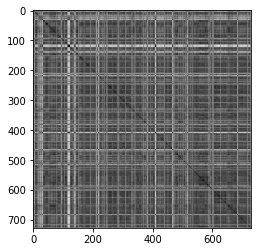

In [5]:
with open('data/tt2024544.pkl', 'rb') as handler:
    data = pickle.load(handler)
    
distances = torch.cdist(data['place'], data['place'], p = 2)
distances += torch.cdist(data['cast'], data['cast'], p = 2)
distances += torch.cdist(data['action'], data['action'], p = 2)
distances += torch.cdist(data['audio'], data['audio'], p = 2)
distances /= 4.
        
plt.imshow(torch.cdist(distances, distances, p = 2), cmap=plt.get_cmap('gray'))

In [6]:
for index, file in enumerate(filenames):
    with open(file, 'rb') as handler:
        data = pickle.load(handler)
        
        ## Here, we take the mean of all the distances matrices
        ## Shots within the same scene should have low distance
        ## value, and shots in different scene would have higher
        ## values.
        
        distances = torch.cdist(data['place'], data['place'], p = 2)
        distances += torch.cdist(data['cast'], data['cast'], p = 2)
        distances += torch.cdist(data['action'], data['action'], p = 2)
        distances += torch.cdist(data['audio'], data['audio'], p = 2)
        distances /= 4.
        
        num_scenes = estimate_scenes_count(distances)
        
        print("[{0}] {1}, num_scenes: {2} actual: {3}".format(index, os.path.basename(file), num_scenes, 
                                                              sum(data['scene_transition_boundary_ground_truth'])))
        
        
        ## Pick only the current boundary predictions with higher
        ## probability keeping track of number of scenes detected
        
        indices = np.argsort(data['scene_transition_boundary_prediction']).tolist()[::-1]

        arr = sorted(data['scene_transition_boundary_prediction'], reverse=True)
        arr[num_scenes:] = [elem / (2. * arr[num_scenes] + 1) for elem in arr]
        data['scene_transition_boundary_prediction'] = torch.tensor([x for _, x in sorted(zip(indices, arr), key = lambda pair: pair[0])])
                    
        filename = 'output/' + os.path.basename(file)
        with open(filename, 'wb') as handler:
            pickle.dump(data, handler)

[0] tt0052357.pkl, num_scenes: 59 actual: 93
[1] tt0063442.pkl, num_scenes: 64 actual: 36
[2] tt0068646.pkl, num_scenes: 61 actual: 196
[3] tt0073195.pkl, num_scenes: 63 actual: 100
[4] tt0075314.pkl, num_scenes: 53 actual: 38
[5] tt0078788.pkl, num_scenes: 75 actual: 105
[6] tt0082089.pkl, num_scenes: 39 actual: 92
[7] tt0086190.pkl, num_scenes: 106 actual: 127
[8] tt0088247.pkl, num_scenes: 88 actual: 48
[9] tt0088944.pkl, num_scenes: 94 actual: 49
[10] tt0092099.pkl, num_scenes: 98 actual: 147
[11] tt0096320.pkl, num_scenes: 55 actual: 113
[12] tt0099423.pkl, num_scenes: 119 actual: 189
[13] tt0100405.pkl, num_scenes: 68 actual: 68
[14] tt0103776.pkl, num_scenes: 89 actual: 108
[15] tt0103855.pkl, num_scenes: 110 actual: 127
[16] tt0107290.pkl, num_scenes: 67 actual: 156
[17] tt0108399.pkl, num_scenes: 99 actual: 118
[18] tt0110604.pkl, num_scenes: 97 actual: 111
[19] tt0112573.pkl, num_scenes: 151 actual: 158
[20] tt0113277.pkl, num_scenes: 102 actual: 192
[21] tt0114746.pkl, num_s

### Evaluation results

In [7]:
!git clone https://github.com/eluv-io/elv-ml-challenge.git
%run elv-ml-challenge/evaluate_sceneseg.py ./output/

Cloning into 'elv-ml-challenge'...


# of IMDB IDs: 64
Scores: {
    "AP": 0.43432948488202827,
    "mAP": 0.456352123550865,
    "Miou": 0.46784292015853995,
    "Precision": 0.5318621161859483,
    "Recall": 0.35784778487868607,
    "F1": 0.4101209096486932
}
